# Code Concepts User Study

### Setup

In [1]:
#!pip install bertviz
#!pip uninstall bertviz

In [2]:
#!pip install python-igraph
#!pip uninstall python-igraph

In [3]:
#!pip install plotly
#!pip uninstall plotly

In [4]:
!pip install ipympl
!pip install networkx
!pip install mplcursors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 15.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mplcursors: filename=mplcursors-0.5.2-py3-none-any.whl size=21054 sha256=5722c2c9f59a821959af03c23079a4388e47b6a9aa0cce8b486c9d7824d89105
  Stored in directory: /root/.cache/pip/wheels/6d/02/b1/7d5c397daf88f75d3432168edddd8b02d3ae2c050ffa7ca26f
Successfully built mplcursors

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


### Imports

In [5]:
#ENCAPSULED
import matplotlib.pyplot as plt
import networkx as nx
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
from statistics import mean
from CodeSyntaxConcept.tokenizer import CodeTokenizer
from CodeSyntaxConcept.parser import TreeSitterParser
import CodeSyntaxConcept.utils as utils
import mplcursors
import random

ModuleNotFoundError: No module named 'CodeSyntaxConcept'

### Parameters

In [ ]:
# specify a checkpoint to use, Transformer based text generation model (GPT)
# https://huggingface.co/models?other=text%20generation 
checkpoint = 'EleutherAI/gpt-neo-125M'

In [ ]:
# specify a source code snippet sample
#prompt = 'def multiply_numbers(number1, number2):\n     return'

# specify a source code snippet sample
prompt = 'def bubblesort(elements):\n    swapped = False\n    # Looping from size of array from last index[-1] to index [0]\n    for n in range(len(elements)-1, 0, -1):\n        for i in range(n):\n            if elements[i] > elements[i + 1]:\n                swapped = True\n                # swapping data if the element is less than next element in the array\n                elements[i], elements[i + 1] = elements[i + 1], elements[i]       \n        if not swapped:\n            # exiting the function if we didn\'t make a single swap\n            # meaning that the array is already sorted.\n            return'

In [ ]:
# programming language of the snippet.
language = "python"

### Processing

In [ ]:
# ENCAPSULTED
text_generator_pipe = pipeline(task='text-generation', model=checkpoint)
text_generator_model = AutoModelForCausalLM.from_pretrained(checkpoint)
text_generator_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
# ENCAPSULTED
#encode
encoded_input = text_generator_tokenizer.encode_plus(prompt, return_tensors='pt', return_offsets_mapping=True)
#generates the original sequence (forward)
encoded_output = text_generator_model(encoded_input['input_ids'])
#encoded_output = text_generator_model.generate(**encoded_input, pad_token_id=text_generator_tokenizer.eos_token_id, max_length=len(encoded_input['input_ids'][0])+10, output_scores=True, return_dict_in_generate=True)
sequence_index = 0 # just 1 snippet

In [ ]:
# ENCAPSULATED
## Actual probability case
def get_actual_probs(encoded_output, encoded_input ,sequence_index, text_generator_tokenizer):
    output_probs = encoded_output['logits'][sequence_index].softmax(dim=0)
    vocabulary_indexes = list(text_generator_tokenizer.get_vocab().values())
    vocabulary_values = list(text_generator_tokenizer.get_vocab().keys())
    sequence = []
    for input_id_index, input_id in enumerate(encoded_input['input_ids'][sequence_index]): ## Eliminate first token
        input_id_location = vocabulary_indexes.index(encoded_input['input_ids'][sequence_index][input_id_index].item())
        input_id_pred_prob = output_probs[input_id_index][input_id_location]
        #sequence.append((input_id.item(), input_id_pred_prob.item()))
        sequence.append((vocabulary_values[input_id_location], input_id_pred_prob.item()))
    return sequence


In [ ]:
# ENCAPSULATED 
## Binds tree with actual probabilities
def bind_bpe_tokens(
    node,              #Tree sitter ast tree
    encodings,          #Token encoding
    actual_probs,      #Actual probabilities
    lines              #Source code Snippet
): 
    """Traverses the tree and bind the leaves with the corresponding node"""
    tree_node = {}
    tree_node['type'] = node.type
    tree_node['children'] = []
    tree_node['bindings'] = []
    tree_node['prob'] = 0

    node_span = [utils.convert_to_offset(node.start_point, lines), utils.convert_to_offset(node.end_point, lines)]
    for encoding_index, token_span in enumerate(encodings):
        if (node_span[0] <= token_span[0] and  
            token_span[0] < node_span[1]) or (node_span[0] < token_span[1] and 
            token_span[1] <= node_span[1]):
            tree_node['bindings'].append(actual_probs[encoding_index])
    
    for n in node.children:
        tree_node['children'].append(bind_bpe_tokens(n, encodings, actual_probs, lines))
    
    tree_node['prob'] = mean([prob for element, prob in tree_node['bindings']])

    return tree_node
        

In [ ]:
# ENCAPSULATED
def create_graph_from_binded_tree(binded_tree):

    def build_graph(graph, binded_ast_node, parent_node_id, labels, attributes):
        node_id = len(graph)
        graph.add_node(node_id)
        attributes[node_id] = {'type': binded_ast_node['type'], 'degree': len(binded_ast_node['children']) + 1, 'prob': binded_ast_node['prob'], 'tokens': [element for element, prob in binded_ast_node['bindings']]}
        labels[node_id] = binded_ast_node['type']
        if parent_node_id is not None:
            graph.add_edge(parent_node_id, node_id)     
        for child in binded_ast_node['children']:
            build_graph(graph, child, node_id, labels, attributes)
    graph = nx.DiGraph()
    labels = {}
    attributes = {}
    build_graph(graph, binded_tree, None, labels, attributes)
    return graph, labels, attributes

In [ ]:
# ENCAPSULATED
## Asociate BPE tokens with terminals
concepts_tokenizer = CodeTokenizer.from_pretrained(checkpoint, language)
actual_probs = get_actual_probs(encoded_output, encoded_input ,sequence_index, text_generator_tokenizer)
tree = concepts_tokenizer.parser.parse(bytes(prompt, "utf8"))
binded_tree = bind_bpe_tokens(tree.root_node, encoded_input['offset_mapping'][sequence_index].tolist(), actual_probs, prompt.split('\n'))

### Visualize

In [ ]:
# ENCAPSULATED
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')
    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))
        else:
            root = random.choice(list(G.nodes))
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

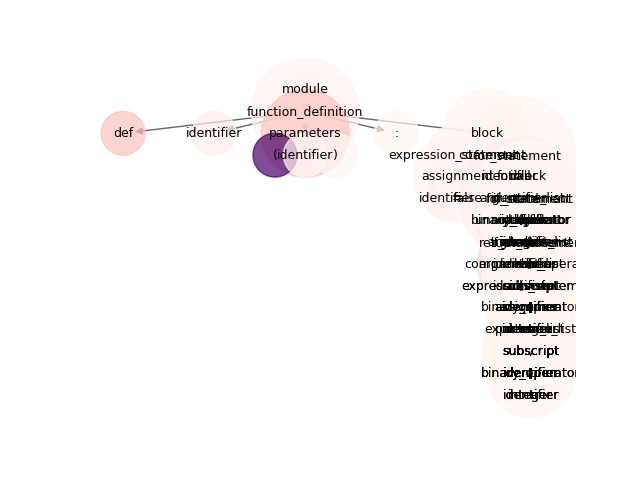

In [ ]:
%matplotlib widget

graph, labels, attributes = create_graph_from_binded_tree(binded_tree)
nx.set_node_attributes(graph, attributes)

#pos = nx.arf_layout(graph)
pos = hierarchy_pos(graph, 0)

node_color = [nx.get_node_attributes(graph, 'prob')[v] for v in graph]
node_size = [graph.degree(v)*1000 for v in graph]

nodes = nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=node_color, cmap = plt.cm.RdPu, alpha = 0.7)
nx.draw_networkx_labels(graph, pos, font_color='black', labels=labels, font_size=9)
nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), edge_color='.4', width=1)

def update_annot(sel):
    node_index = sel.target.index
    node_name = list(graph.nodes)[node_index]
    node_attr = graph.nodes[node_name]
    text = 'prob: ' + str(round(node_attr['prob'],4)) + '\n' \
        + 'tokens: ' + str(node_attr['tokens'])
    sel.annotation.set_text(text)

cursor = mplcursors.cursor(nodes, hover=True)
cursor.connect('add', update_annot)


plt.rcParams["figure.figsize"] = (10,5)
plt.axis("off")
plt.show()